## Deep Reinforcement Learning - Project Work
### Daniel Kuknyo 
#### Task Description:
During the project work, you need to implement and use, study and compare the following algorithms:  

- Deep Q-learning (DQN),
- Double DQN,
- Dueling DQN
- Policy iteration method that uses the advantage function (actor critic methods)  

Do the trials, solve your chosen problem using these algorithms and in the end write a study about your work, your experiences and finds. Be precise, not long. We'd like to see well written, straightforward study, not long ones. 

Before you start, please check out the Sutton-Barto book on Reinforcement Learning and study the examples shown there. In example: Figure 2.1, 2.3, 5.3. Example 5.3, 5.5, 6.2, 6.6. Go through them and try to do a statistic analysis similar to the one used in those examples in your work.  

Project work hints:  
You can find algorithm implementations here:  
https://github.com/topics/ddqn?o=asc&s=forks  
https://chuacheowhuan.github.io/Duel_DDQN/  
https://github.com/topics/reinforce  
https://towardsdatascience.com/policy-gradient-reinforce-algorithm-with-baseline-e95ace11c1c4  
https://github.com/topics/reinforcement-learning?l=jupyter+notebook  
And of course on so many other links. Careful: We need you to show your own work. So if you use those codes you can find the links above, use them as an inspiration and not just copy the code. If we find exact match without proper referencing it will be considered as cheating and we zero you project.  
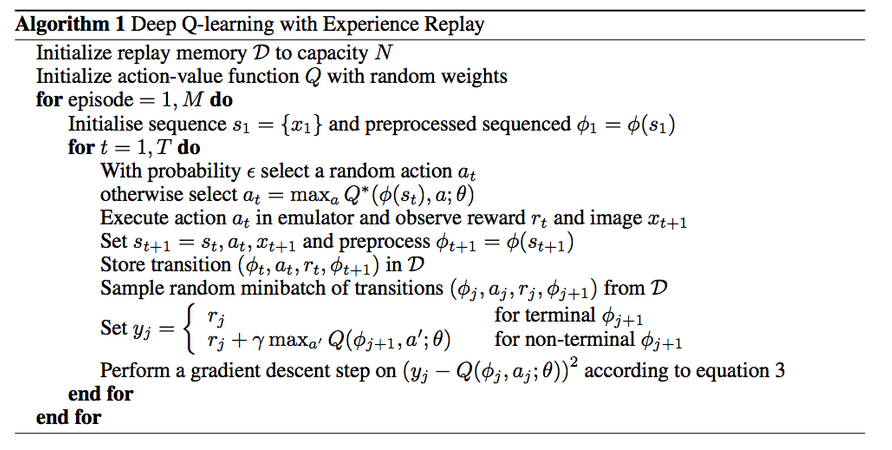

## Double Deep Q-Learning
### Libraries

In [1]:
import gym
import random 
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import base64, io
from collections import deque
from collections import namedtuple

import ffmpeg
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

mpl.rc('animation', html='jshtml')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings('ignore')

### Visualization functions

In [21]:
# Set the scene variable
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Plot some sequential frames after eachother
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Input a Neural Network and play an episode in it
def render_policy_net(agent, n_max_steps=500, seed=42, done_close=True, epsilon=0):
    env = gym.make(env_name)
    obs = env.reset()
    frames = []
    rewards = []
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        
        action = agent.act(obs)
        obs, reward, done, info = env.step(action) # Execute step
        rewards.append(reward)
        
        if(done_close and done):
            break

    env.close()
    return frames, rewards

# Where to save figure
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Save a figure in a nice format
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# A simple function to plot the rewards of an entire training session or a single iteration
def plot_rewards(rewards, episode=True):
    n = len(rewards)
    if(episode): # Single iteration
        df = pd.DataFrame({'Rewards': rewards, 'Step': np.arange(n)})
        sns.lineplot(data=df, x='Step', y='Rewards').set(title="Rewards across "+str(n)+" steps in episode:")
    else: # Multiple epochs of training
        df = pd.DataFrame({'Rewards': rewards, 'Epoch': np.arange(n)})
        sns.lineplot(data=df, x='Epoch', y='Rewards').set(title="Rewards across "+str(n)+" episodes")

### Setup
#### Environment

In [4]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


#### Network
This will be a very basic torchvision model.

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size): # Define the architecture
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state): # Get predictions from the layers
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

#### Hyperparameters
Figuring out these can take some experimentation but these values seem to work well.

In [6]:
BUFFER_SIZE = int(1e5) # Replay buffer size
BATCH_SIZE = 64 # Minibatch size
GAMMA = 0.99 # Discount factor
TAU = 1e-3 # For soft update of target parameters
LR = 5e-4 # Learning rate 
UPDATE_EVERY = 4 # How often to update the network

#### Agent
The methods here are standard for a DQN Agent. 

In [7]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.mse_track = []
        self.qnetwork_local = QNetwork(state_size, action_size) # Local network (for every step)
        self.qnetwork_target = QNetwork(state_size, action_size) # Target network (for UPDATE_EVERY)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0 # Initialize time step (for UPDATE_EVERY) 
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done) # Save experience in replay memory
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if(self.t_step == 0): # If there's enough experience in the memory we will sample it and learn 
            if(len(self.memory) > BATCH_SIZE):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.): # Take some action based on state
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if(random.random() > eps): # Epsilon-greedy action selection
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences # Obtain a random mini-batch

        # Compute and minimize the loss
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones) # Q-values calculation
        q_expected = self.qnetwork_local(states).gather(1, actions) # Expectation value from the loval network
        
        # Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.mse_track.append(loss) # Keeping track of the loss values here for further plotting
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) # Update the target network

    def soft_update(self, local_model, target_model, tau): # We can update the target model regularized by tau to avoid overfitting
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

#### ReplayBuffer

In [8]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size) # Sample the replay buffer uniformly

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

### Run the learning
First, variables

In [9]:
n_episodes = 3000 # Maximum number of episodes
max_t = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
eps = eps_start # Init epsilon

agent = Agent(state_size=8, action_size=4)

scores = [] # We will keep track of the scores here
scores_window = deque(maxlen=100) # Keep track of the last 100 iterations

Play for a total of max. 3000 episodes

In [10]:
for i_episode in range(1, n_episodes+1): # Run for all episodes
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = agent.act(state, eps) # Take an action (epsilon-greedy) using the current state and decayed epsilon
        next_state, reward, done, _ = env.step(action) # Observe the environment
        agent.step(state, action, reward, next_state, done) # Update the agent
        state = next_state
        score += reward
        
        if(done):
            break

    scores_window.append(score) # Save most recent score
    scores.append(score) # Save most recent score
    eps = max(eps_end, eps_decay*eps) # Decay epsilon --> start with exploration, end with exploitation
    
    if(i_episode % 100 == 0): # Every 100 episodes print out some data
        print('Episode: '+str(i_episode)+', Average score: '+str(np.mean(scores_window)))
        
    if(np.mean(scores_window) >= 200): # Consider the task solved if the reward is over 200
        print('Environment solved in: '+str(i_episode-100)+" episodes.")
        print('Average score at solution: '+str(np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_DDQN_local.pth') # Save model
        torch.save(agent.qnetwork_target.state_dict(), 'checkpoint_DDQN_target.pth') # Save model
        break


Episode: 100, Average score: -169.55581417359687
Episode: 200, Average score: -145.62257255533208
Episode: 300, Average score: -61.691158172919714
Episode: 400, Average score: -18.100090656050792
Episode: 500, Average score: 21.371430708137545
Episode: 600, Average score: 163.23559883229697
Environment solved in: 592 episodes.
Average score at solution: 200.05553593422354


### Let's plot the rewards

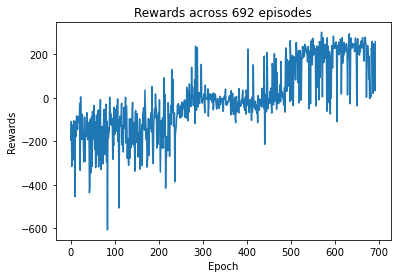

In [11]:
plot_rewards(scores, episode=False)

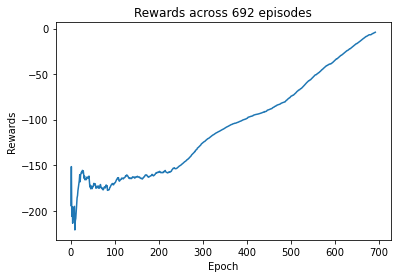

In [12]:
avg_rew_calc = lambda x: [np.mean(x[:i+1]) for i in range(len(x))]
average_rewards = avg_rew_calc(scores)

plot_rewards(average_rewards, episode=False)

In [13]:
frames, rewards = render_policy_net(agent)
plot_animation(frames)

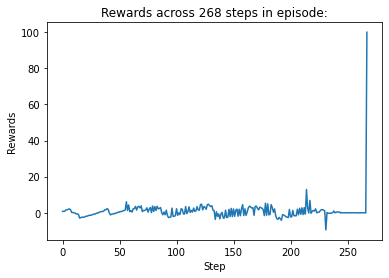

In [14]:
plot_rewards(rewards)

#### Measure the MSE

In [30]:
errors = [np.float64(x) for x in agent.mse_track]
mean_errors = [np.mean(errors[:x+1]) for x in range(len(errors))]

Saving figure MSE_track_DDQN


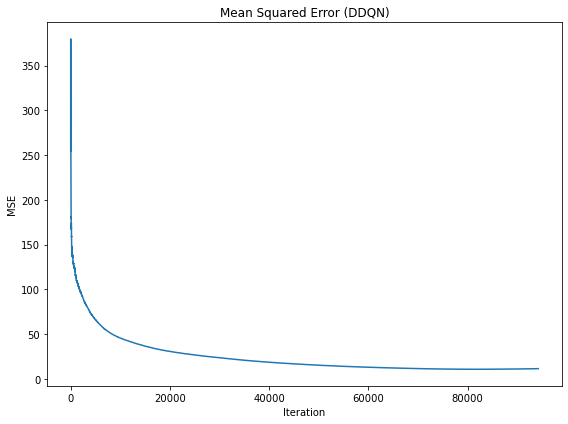

In [31]:
df = pd.DataFrame({"Iteration":np.arange(len(agent.mse_track))+1, "MSE":mean_errors})
df.to_csv('MSE_DDQN.csv', sep=',', index=False)
plt.figure(figsize=(8,6))
plt.title("Mean Squared Error (DDQN)")
ax = sns.lineplot(x="Iteration", y="MSE", data=df)
save_fig("MSE_track_DDQN")
plt.show()